# Clipping

I used QGIS to convert a selection of the Ealing TopographicLine and TopographicArea layers to new GIS gpkg files. Thus dramatically reducing the size of the data to play with. Followed instructions at this link

https://www.gislounge.com/convert-selection-new-gis-data-using-qgis/


Wasn't able to work out how to get Line and Area layers into one gpkg file, so left them separate for now. 


## Libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import mplleaflet
import folium
import fiona
import pyproj
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_column', 100) #set max number of cols to display before ...

from rasterio._base import gdal_version
import rasterio
import rasterio.warp
import rasterio.features
from rasterio import plot #essential to plot images in BNG, in correct posiiton, and full RGB 

import contextily
import shapely as shp

In [2]:
import shapely as shp

## Ealing Topo Line 1980 tile

In [3]:
#set path to etopoLine_1980
eLine_path = "../data/eTopoLine_1980/eTopoLine_1980.gpkg"

In [4]:
#just one layer
for layername in fiona.listlayers(eLine_path):
    with fiona.open(eLine_path, layer=layername) as src:
        print(layername, len(src))

etopoLine_1980 19788


In [16]:
eLine = gpd.read_file(eLine_path)

In [28]:
eLine.head()

id  OBJECTID              TOID  FeatureCode  Version  \
0  1756467   1756467  1000001793846348        10046        1   
1  1756468   1756468  1000001778704570        10019        3   
2  1756469   1756469  1000001778704608        10168        4   
3  1756470   1756470  1000001778706046        10168        5   
4  1756471   1756471  1000001778707422        10168        3   

           VersionDate                              Theme  ThemeCount  \
0  2007-01-02T00:00:00                     Buildings,Land           2   
1  2007-12-16T00:00:00                     Buildings,Land           2   
2  2018-04-26T00:00:00             Roads Tracks And Paths           1   
3  2020-01-31T00:00:00  Roads Tracks And Paths,Structures           2   
4  2020-01-31T00:00:00  Roads Tracks And Paths,Structures           2   

  AccuracyOfPosition           ChangeDate ReasonForChange  ChangeHistoryCount  \
0               1.0m  2006-12-06T00:00:00    Restructured                   2   
1               1.0m  2007-10-11T00:00:00      Attributes                   3   
2               1.0m  2018-04-26T00:00:00      Attributes                   5   
3               1.0m  2020-01-31T00:00:00        Modified                   5   
4               1.0m  2020-01-31T00:00:00      Attributes                   3   

  DescriptiveGroup  DescriptiveGroupCount DescriptiveTerm  \
0  General Feature                      1            None   
1         Building                      1         Outline   
2    Road Or Track                      1          Public   
3    Road Or Track                      1          Public   
4    Road Or Track                      1          Public   

   DescriptiveTermCount  NonBoundingLine HeightAboveDatum  \
0                   NaN              NaN             None   
1                   1.0              NaN             None   
2                   1.0              NaN             None   
3                   1.0              NaN             None   
4                   1.0              NaN             None   

  AccuracyOfHeightAboveDatum HeightAboveGroundLevel  \
0                       None                   None   
1                       None                   None   
2                       None                   None   
3                       None                   None   
4                       None                   None   

  AccuracyOfHeightAboveGroundLevel     Make  PhysicalLevel PhysicalPresence  \
0                             None     None             50      Obstructing   
1                             None  Manmade             50      Obstructing   
2                             None  Manmade             50     Edge / Limit   
3                             None  Manmade             50     Edge / Limit   
4                             None  Manmade             50     Edge / Limit   

  ReferenceToFeature broken  SHAPE_Length  \
0               None  false      1.092384   
1               None  false      4.636972   
2               None  false     30.522428   
3               None  false     22.420721   
4               None  false     12.663172   

                                            geometry  
0  LINESTRING (519562.500 179999.400, 519562.100 ...  
1  LINESTRING (519788.600 180000.500, 519787.050 ...  
2  LINESTRING (519861.060 179989.460, 519860.950 ...  
3  LINESTRING (519858.750 180012.689, 519858.750 ...  
4  LINESTRING (519858.450 179990.450, 519858.250 ...

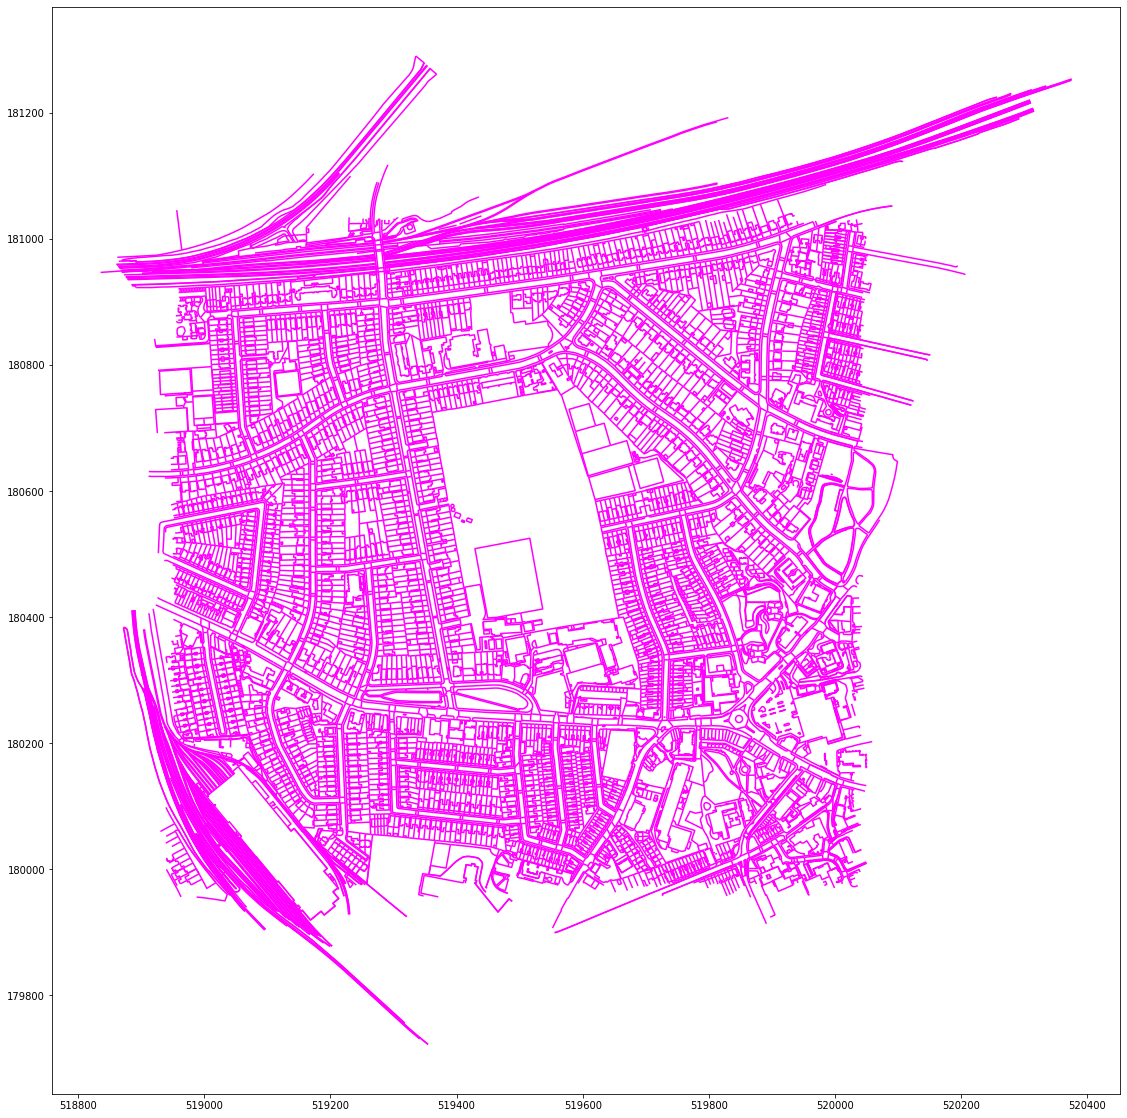

In [17]:
eLine.plot(figsize=(20,20), color = "magenta")

(180800, 181000)

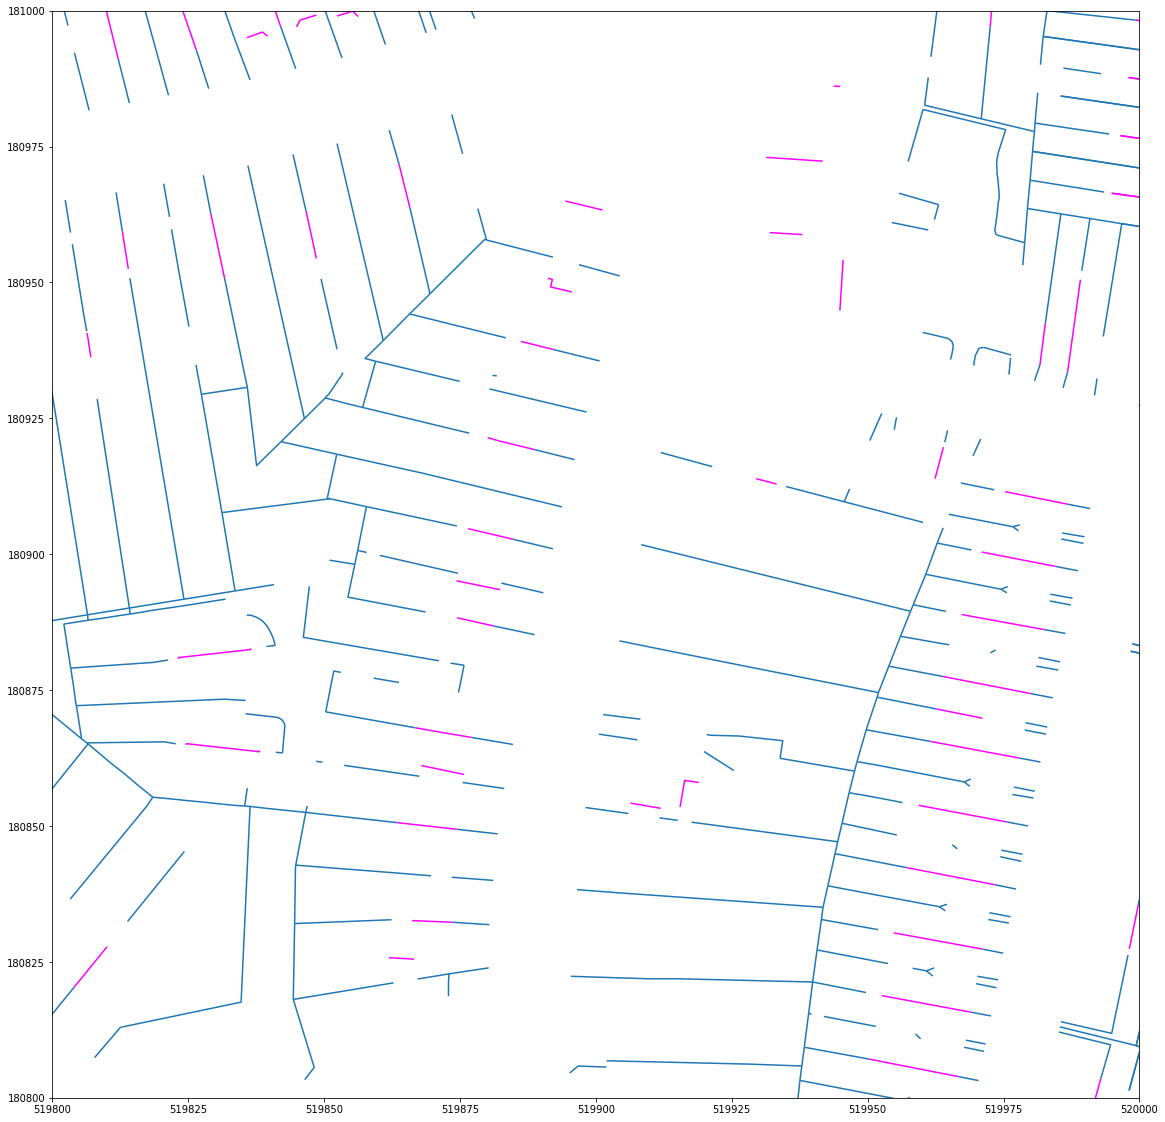

In [38]:
base = eLine.query("Theme == 'Land'").plot(figsize = (20,20))
eLine.query("Theme == 'Buildings'").plot(figsize = (20,20), color = "magenta", ax = base)
base.set_xlim(519800, 520000)
base.set_ylim(180800,181000)
#these are just line segments, they don't overlap they mark the edges of gardens, buildings, but weirdly not 
#all buildings?

In [7]:
eLine.head()

id  OBJECTID              TOID  FeatureCode  Version  \
0  1756467   1756467  1000001793846348        10046        1   
1  1756468   1756468  1000001778704570        10019        3   
2  1756469   1756469  1000001778704608        10168        4   
3  1756470   1756470  1000001778706046        10168        5   
4  1756471   1756471  1000001778707422        10168        3   

           VersionDate                              Theme  ThemeCount  \
0  2007-01-02T00:00:00                     Buildings,Land           2   
1  2007-12-16T00:00:00                     Buildings,Land           2   
2  2018-04-26T00:00:00             Roads Tracks And Paths           1   
3  2020-01-31T00:00:00  Roads Tracks And Paths,Structures           2   
4  2020-01-31T00:00:00  Roads Tracks And Paths,Structures           2   

  AccuracyOfPosition           ChangeDate ReasonForChange  ChangeHistoryCount  \
0               1.0m  2006-12-06T00:00:00    Restructured                   2   
1               1.0m  2007-10-11T00:00:00      Attributes                   3   
2               1.0m  2018-04-26T00:00:00      Attributes                   5   
3               1.0m  2020-01-31T00:00:00        Modified                   5   
4               1.0m  2020-01-31T00:00:00      Attributes                   3   

  DescriptiveGroup  DescriptiveGroupCount DescriptiveTerm  \
0  General Feature                      1            None   
1         Building                      1         Outline   
2    Road Or Track                      1          Public   
3    Road Or Track                      1          Public   
4    Road Or Track                      1          Public   

   DescriptiveTermCount  NonBoundingLine HeightAboveDatum  \
0                   NaN              NaN             None   
1                   1.0              NaN             None   
2                   1.0              NaN             None   
3                   1.0              NaN             None   
4                   1.0              NaN             None   

  AccuracyOfHeightAboveDatum HeightAboveGroundLevel  \
0                       None                   None   
1                       None                   None   
2                       None                   None   
3                       None                   None   
4                       None                   None   

  AccuracyOfHeightAboveGroundLevel     Make  PhysicalLevel PhysicalPresence  \
0                             None     None             50      Obstructing   
1                             None  Manmade             50      Obstructing   
2                             None  Manmade             50     Edge / Limit   
3                             None  Manmade             50     Edge / Limit   
4                             None  Manmade             50     Edge / Limit   

  ReferenceToFeature broken  SHAPE_Length  \
0               None  false      1.092384   
1               None  false      4.636972   
2               None  false     30.522428   
3               None  false     22.420721   
4               None  false     12.663172   

                                            geometry  
0  LINESTRING (519562.500 179999.400, 519562.100 ...  
1  LINESTRING (519788.600 180000.500, 519787.050 ...  
2  LINESTRING (519861.060 179989.460, 519860.950 ...  
3  LINESTRING (519858.750 180012.689, 519858.750 ...  
4  LINESTRING (519858.450 179990.450, 519858.250 ...

## Ealing Topo Area 1980 tile 

In [5]:
#set path
eArea_path = "../data/eTopoArea_1980/eTopoArea_1980.gpkg"

In [6]:
#just one layer - expected this to have 2 layers but seems to have mushed them or only given area layer
for layername in fiona.listlayers(eArea_path):
    with fiona.open(eArea_path, layer=layername) as src:
        print(layername, len(src))

eTopoArea_1980 7200


In [7]:
eArea = gpd.read_file(eArea_path)


In [8]:
eArea.head()

id  OBJECTID              TOID  FeatureCode  Version  \
0  643242    643242  5000005125902538        10123        1   
1  643243    643243  1000001793846362        10056        2   
2  643244    643244  1000001793846365        10056        2   
3  643251    643251  1000001778929145        10056        4   
4  643252    643252  1000001778929144        10056        6   

           VersionDate                   Theme  ThemeCount  \
0  2014-05-29T00:00:00  Roads Tracks And Paths           1   
1  2008-03-18T00:00:00                    Land           1   
2  2008-03-18T00:00:00                    Land           1   
3  2008-03-18T00:00:00                    Land           1   
4  2014-05-29T00:00:00                    Land           1   

   CalculatedAreaValue           ChangeDate ReasonForChange  \
0            44.669666  2014-04-29T00:00:00             New   
1            66.485440  2006-12-06T00:00:00             New   
2            32.208200  2006-12-06T00:00:00             New   
3            14.644856  2006-12-06T00:00:00             New   
4          1152.839530  2014-04-29T00:00:00        Modified   

   ChangeHistoryCount DescriptiveGroup  DescriptiveGroupCount DescriptiveTerm  \
0                   1             Path                      1            None   
1                   1  General Surface                      1            None   
2                   1  General Surface                      1            None   
3                   1  General Surface                      1            None   
4                   3  General Surface                      1            None   

   DescriptiveTermCount     Make  PhysicalLevel PhysicalPresence broken  \
0                   NaN  Manmade             50             None  false   
1                   NaN  Natural             50             None  false   
2                   NaN  Natural             50             None  false   
3                   NaN  Natural             50             None  false   
4                   NaN  Manmade             50             None  false   

   SHAPE_Length   SHAPE_Area  \
0     32.838010    44.669666   
1     47.312817    66.485450   
2     34.586030    32.208200   
3     51.548592    14.644850   
4    299.453631  1152.839530   

                                            geometry  
0  POLYGON ((519539.020 179987.631, 519545.071 17...  
1  POLYGON ((519561.040 179973.500, 519560.150 17...  
2  POLYGON ((519506.710 179985.100, 519507.260 17...  
3  POLYGON ((519513.020 180000.000, 519513.250 18...  
4  POLYGON ((519512.340 180007.310, 519514.020 18...

In [9]:
eArea.dtypes

id                          int64
OBJECTID                    int64
TOID                       object
FeatureCode                 int64
Version                     int64
VersionDate                object
Theme                      object
ThemeCount                  int64
CalculatedAreaValue       float64
ChangeDate                 object
ReasonForChange            object
ChangeHistoryCount          int64
DescriptiveGroup           object
DescriptiveGroupCount       int64
DescriptiveTerm            object
DescriptiveTermCount      float64
Make                       object
PhysicalLevel               int64
PhysicalPresence           object
broken                     object
SHAPE_Length              float64
SHAPE_Area                float64
geometry                 geometry
dtype: object

In [10]:
#count theme types
eArea['Theme'].value_counts()

Land                                 3430
Buildings                            2916
Roads Tracks And Paths                785
Rail                                   40
Roads Tracks And Paths,Structures      14
Structures                              7
Land,Rail                               5
Rail,Structures                         2
Water                                   1
Name: Theme, dtype: int64

In [11]:
eArea['DescriptiveGroup'].value_counts()

General Surface             3384
Building                    2916
Road Or Track                429
Roadside                     207
Path                         149
Rail                          40
Landform                      30
Roadside,Structure            13
Natural Environment           13
Structure                      7
Natural Environment,Rail       5
Unclassified                   3
Rail,Structure                 2
Road Or Track,Structure        1
Inland Water                   1
Name: DescriptiveGroup, dtype: int64

In [12]:
eArea['DescriptiveTerm'].value_counts()

Multi Surface                                 2723
Traffic Calming                                 93
Slope                                           30
Electricity Sub Station                         16
Step                                            13
Scrub                                            6
Upper Level Of Communication                     5
Nonconiferous Trees,Scrub                        5
Nonconiferous Trees                              5
Bridge                                           3
Tank                                             3
Rail Signal Gantry                               2
Coniferous Trees,Nonconiferous Trees,Scrub       1
Scrub,Nonconiferous Trees                        1
Static Water                                     1
Archway                                          1
Name: DescriptiveTerm, dtype: int64

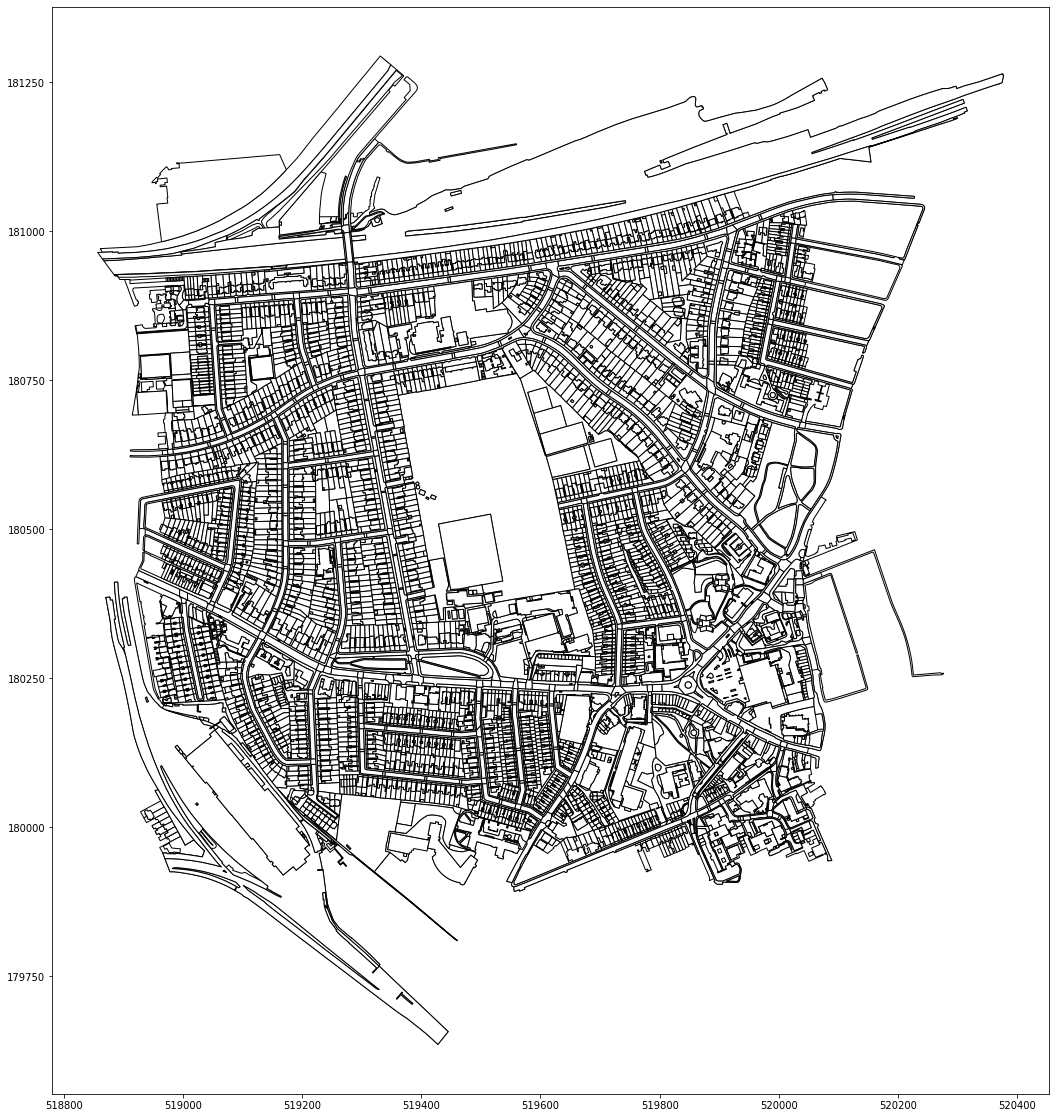

In [13]:
eArea.plot(figsize=(20,20), color = "white", edgecolor = "black")

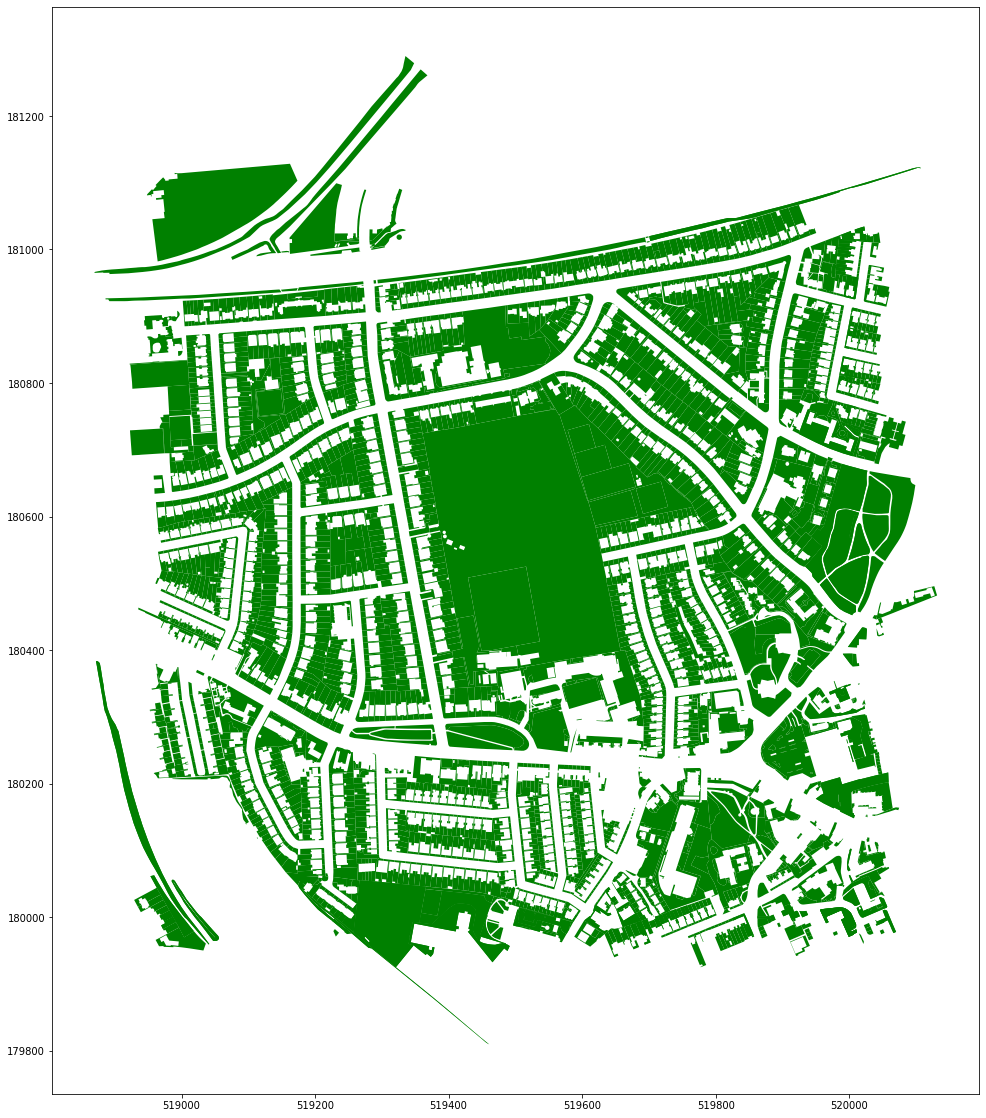

In [29]:
eArea.query("Theme == 'Land'").plot(figsize=(20,20), color = "green")
#Theme == Land includes all rear/front gardens

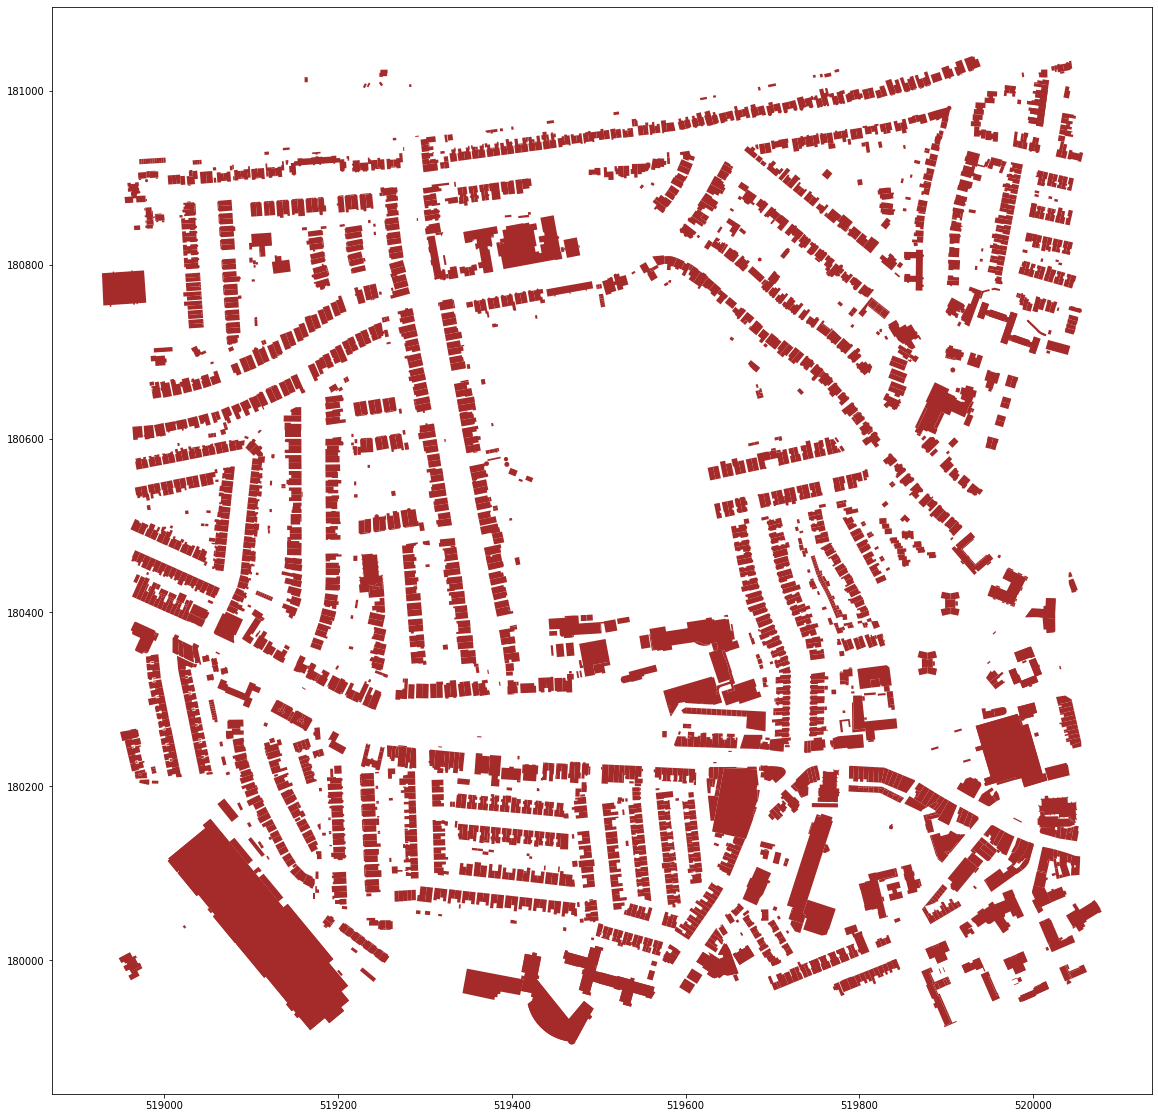

In [31]:
eArea.query("Theme == 'Buildings'").plot(figsize=(20,20), color = "brown")
#Theme == Buildings includes all buildings

(180800, 181000)

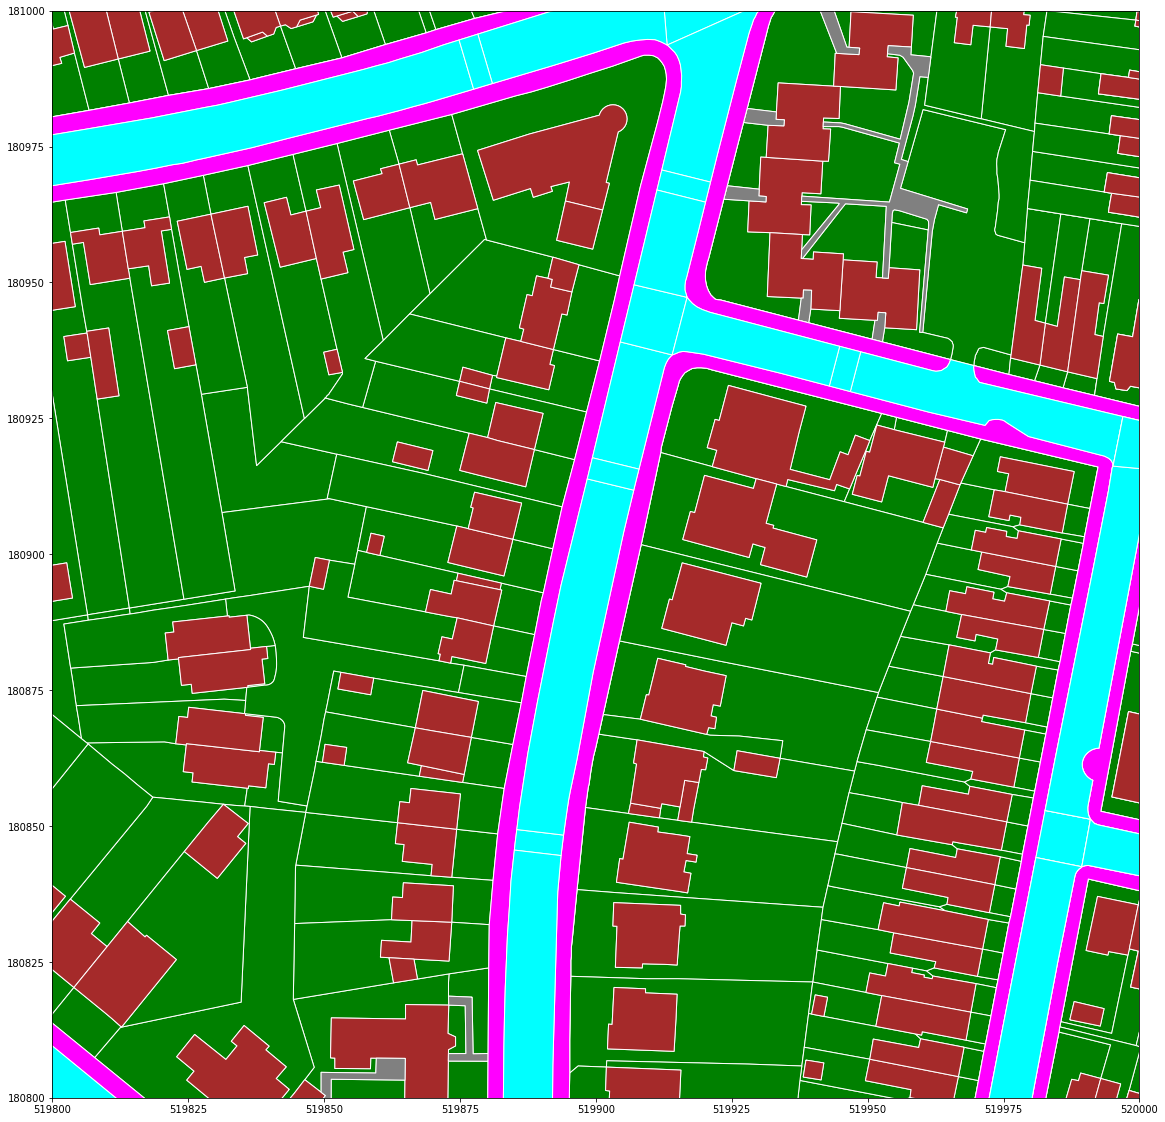

In [17]:
base = eArea.query("Theme == 'Land'").plot(figsize = (20,20), color = 'green', edgecolor = 'white')
eArea.query("Theme == 'Buildings'").plot(figsize = (20,20), color = "brown", ax = base, edgecolor = 'white')
eArea.query("DescriptiveGroup == 'Path'").plot(figsize = (20,20), color = "grey", ax = base, edgecolor = 'white')
eArea.query("DescriptiveGroup == 'Roadside'").plot(figsize = (20,20), color = "magenta", ax = base, edgecolor = 'white')
eArea.query("DescriptiveGroup == 'Road Or Track'").plot(figsize = (20,20), color = "cyan", ax = base, edgecolor = 'white')

base.set_xlim(519800, 520000)
base.set_ylim(180800,181000)
#The gardens and buildings polygons are separate 
#here Land does not include path - will need to include path I think
#need to look into TOID and parent TOID; I think gardens and buildings of the same property should have these
#links recorded
#need to plot with TOID info!!!
#where separate the front garden polygon must be a separate geometry. Don't know if multipolygons are included.

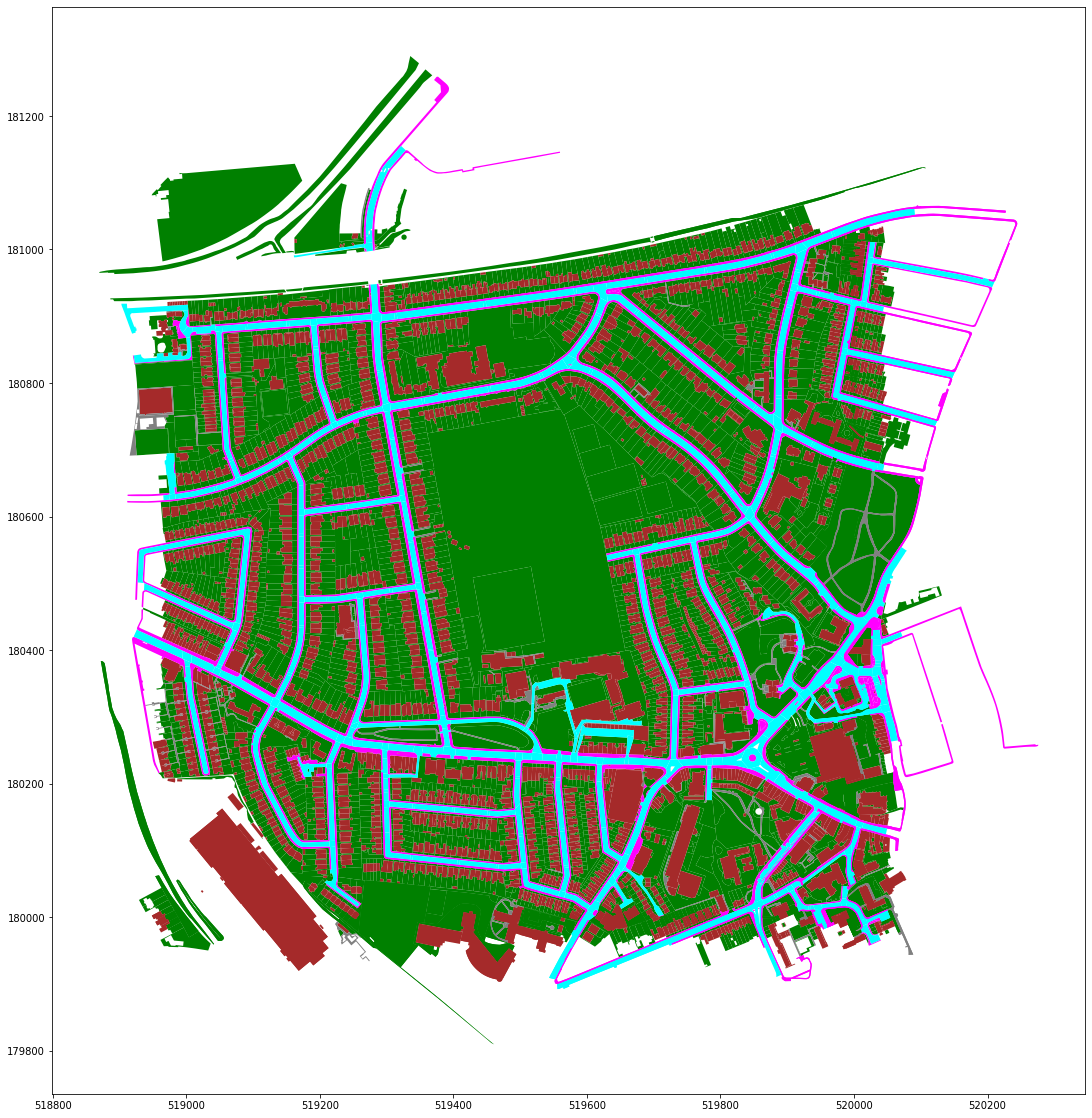

In [47]:
base = eArea.query("Theme == 'Land'").plot(figsize = (20,20), color = 'green')
eArea.query("Theme == 'Buildings'").plot(figsize = (20,20), color = "brown", ax = base)
eArea.query("DescriptiveGroup == 'Path'").plot(figsize = (20,20), color = "grey", ax = base)
eArea.query("DescriptiveGroup == 'Roadside'").plot(figsize = (20,20), color = "magenta", ax = base)
eArea.query("DescriptiveGroup == 'Road Or Track'").plot(figsize = (20,20), color = "cyan", ax = base)

## Load AP 1980 tif


In [24]:
eAP_path = '../data/APEaling_111706_20200601/25cm_Aerial_Photo/111706-1_RGB_1_Shape/TQ1980.tif'
src = rasterio.open(eAP_path)
print("path: ", src.name, "\nmode: ", src.mode, "\nis closed?: ", src.closed
      , "\nband count: ", src.count, "\nshape: ", src.shape, "\nprofile: ", src.profile)


path:  ../data/APEaling_111706_20200601/25cm_Aerial_Photo/111706-1_RGB_1_Shape/TQ1980.tif 
mode:  r 
is closed?:  False 
band count:  3 
shape:  (4000, 4000) 
profile:  {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 4000, 'height': 4000, 'count': 3, 'crs': CRS.from_epsg(27700), 'transform': Affine(0.25, 0.0, 519000.0,
       0.0, -0.25, 181000.0), 'tiled': False, 'interleave': 'pixel'}


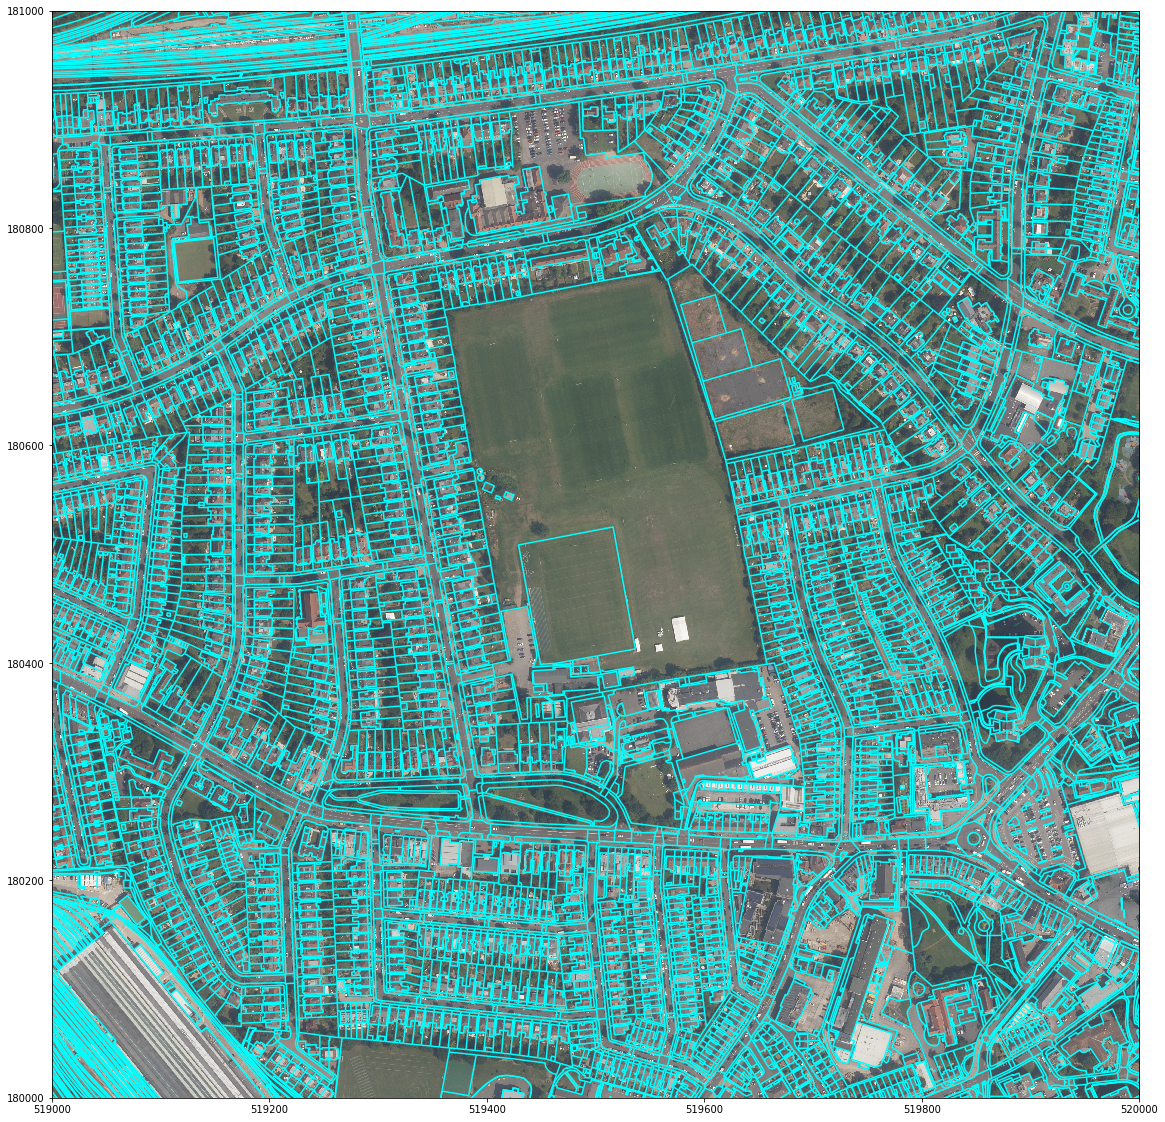

In [26]:
base = eLine.plot(figsize=(20,20), color = "cyan") #uses gpd plot method
plot.show(src, ax = base) #uses rasterio plot module

## Create 1980 bbox to filter eArea 
- I don't remember why I did this; I already have the Topo for just 1980 tile?
- Maybe I wanted to actually make a smaller area from within the 1980 Topo Area layer?
- I can use the method : gpd.overlay(eArea, gdf_bbox, how='intersection') to clip the AP image for a polygon from the Topo layer; but only if that polygon is first made into a geodataframe (there must be a better way!)

https://gis.stackexchange.com/questions/266730/filter-by-bounding-box-in-geopandas

In [129]:
bbox1980 = shp.geometry.box(minx = 519000, miny = 180000, maxx = 520000, maxy = 181000)
#shp.geometry.box(minx, miny, maxx, maxy, ccw=True)

In [107]:
bbox1980.exterior.xy

(array('d', [520000.0, 520000.0, 519000.0, 519000.0, 520000.0]),
 array('d', [180000.0, 181000.0, 181000.0, 180000.0, 180000.0]))

In [108]:
list(bbox1980.exterior.coords)

[(520000.0, 180000.0),
 (520000.0, 181000.0),
 (519000.0, 181000.0),
 (519000.0, 180000.0),
 (520000.0, 180000.0)]

In [109]:
list(zip(*bbox1980.exterior.xy))

[(520000.0, 180000.0),
 (520000.0, 181000.0),
 (519000.0, 181000.0),
 (519000.0, 180000.0),
 (520000.0, 180000.0)]

In [78]:
bbox1980.exterior.xy[0]

array('d', [520000.0, 520000.0, 519000.0, 519000.0, 520000.0])

In [79]:
bbox1980.exterior.xy[1]

array('d', [180000.0, 181000.0, 181000.0, 180000.0, 180000.0])

In [110]:
#create WKT string of polygon box - could not find a way to access this already
#WKT example in WGS
#POLYGON ((-0.85989 53.695421, -0.88696 53.695421, -0.88696 53.70533, -0.85989 53.70533, -0.85989 53.695421))
bbox_str = "POLYGON ((" 
for i in np.arange(5):
    bbox_str = bbox_str + str(bbox1980.exterior.xy[0][i]) + " " + str(bbox1980.exterior.xy[1][i]) + ", ";
    
bbox_str = bbox_str[:-2] + "))" #chop off the final ", " and end the end "))"

bbox_str

'POLYGON ((520000.0 180000.0, 520000.0 181000.0, 519000.0 181000.0, 519000.0 180000.0, 520000.0 180000.0))'

In [122]:
#create dataframe with box in 
data = {'bbox':[bbox_str]}
df = pd.DataFrame(data, columns = ['bbox'])
df['bbox'] = df['bbox'].apply(shp.wkt.loads)

In [123]:
df.head()

bbox
0  POLYGON ((520000 180000, 520000 181000, 519000...

In [124]:
#create geodataframe from df
gdf_bbox = gpd.GeoDataFrame(df, crs = "EPSG:27700", geometry = 'bbox')

In [125]:
eArea1980 = gpd.overlay(eArea, gdf_bbox, how='intersection')
#includes only those polygons that are entirely inside the box

In [127]:
eArea1980.shape

(6425, 23)

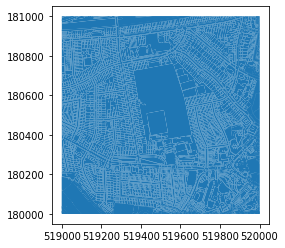

In [130]:
eArea1980.plot()

## Select land polygons next to pavement